In [1]:
%matplotlib inline

import os
from matplotlib_inline import backend_inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import scipy.io
from datetime import datetime
import pywt
import torch
from torch import nn

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)


len(Battery['B0005'][0]), len(Battery['B0005'][1])

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_4160\3691274653.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


(168, 168)

### 移动平均滤波

Text(0, 0.5, 'Capacity')

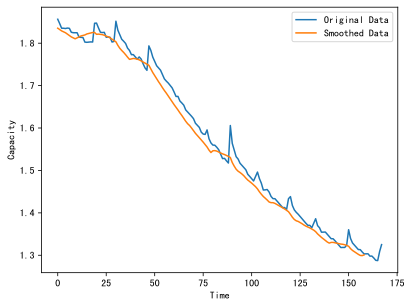

In [27]:
# 原始的锂电池容量衰退数据
original_data = Battery['B0005'][1]

# 移动平均滤波函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 使用移动平均进行数据平滑
window_size = 10  # 滑动窗口大小
smoothed_data = moving_average(original_data, window_size)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 傅立叶变换

Text(0, 0.5, 'Capacity')

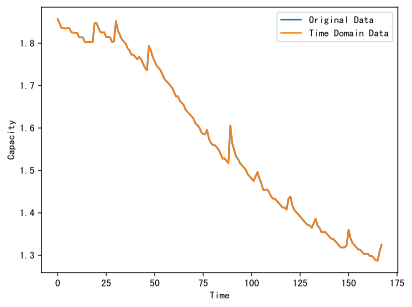

In [4]:
# 原始的锂电池容量衰退数据
original_data = Battery['B0005'][1]

# 傅立叶变换
fft_data = fft(original_data)

# 反傅立叶变换
ifft_data = ifft(fft_data)

# 可视化原始数据和反傅立叶变换后的数据
plt.plot(original_data, label='Original Data')
plt.plot(ifft_data.real, label='Time Domain Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 小波平滑（Wavelet Smoothing）

168
[3.67707439 3.69852374 3.66410196 3.69127252 3.6877568  3.66715618
 3.6495034  3.61016651 3.62857495 3.67220473 3.62272    3.65138126
 3.62574971 3.56225812 3.52764103 3.51744257 3.53298738 3.46591079
 3.41150125 3.35686408 3.3022316  3.25415535 3.19803569 3.16194629
 3.12255744 3.04870338 3.12330232 3.0550865  2.9902755  2.97579552
 2.93731218 2.89261448 2.84789833 2.84091573 2.83395233 2.7814641
 2.74422792 2.74707997 2.71035628 2.68610491 2.6360784  2.67435236
 2.64876807 2.6180628  2.58763731 2.61316062 2.62866648]
47
[ 0.  0. -0. -0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0.  0.  0.  0.
 -0. -0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0.
  0.  0. -0.  0.  0.  0. -0.  0. -0.  0. -0.]
47


Text(0, 0.5, 'Capacity')

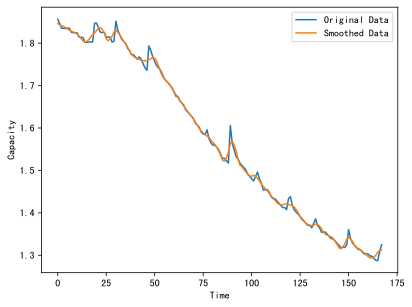

In [3]:
# 原始的时间序列数据
original_data = Battery['B0005'][1]
print(len(original_data))

# 小波平滑函数
def wavelet_smoothing(data, wavelet='db4', level=2):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 1.5
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    print(coeffs[0])
    print(len(coeffs[0]))
    print(coeffs[1])
    print(len(coeffs[1]))
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

# 使用小波平滑
smoothed_data = wavelet_smoothing(original_data)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### Kalman滤波

Text(0, 0.5, 'Capacity')

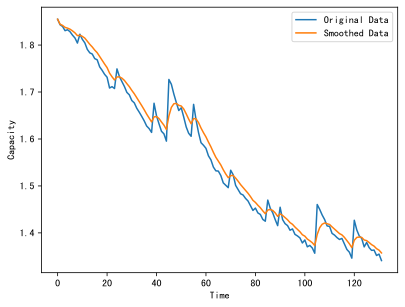

In [20]:
# 原始的时间序列数据
original_data = Battery['B0018'][1]

# Kalman滤波函数
def kalman_filter(data, process_variance, measurement_variance):
    # 初始化滤波器参数
    state = data[0]  # 初始状态
    state_estimate = state
    estimate_error = 1.0
    
    # 存储平滑后的数据
    smoothed_data = [state]
    
    for measurement in data[1:]:
        # 预测步骤
        prediction = state_estimate
        prediction_error = estimate_error + process_variance
        
        # 更新步骤
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        state_estimate = prediction + kalman_gain * (measurement - prediction)
        estimate_error = (1 - kalman_gain) * prediction_error
        
        # 存储平滑后的数据
        smoothed_data.append(state_estimate)
        state = state_estimate
    
    return np.array(smoothed_data)

# 使用Kalman滤波
process_variance = 0.01  # 系统噪音方差
measurement_variance = 0.1  # 观测噪音方差
smoothed_data = kalman_filter(original_data, process_variance, measurement_variance)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 测试利用小波分解增加浮点数据维度

168
4
41
41
59
95


D:\programs\miniconda3\envs\torch-gpu\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Text(0, 0.5, 'Capacity')

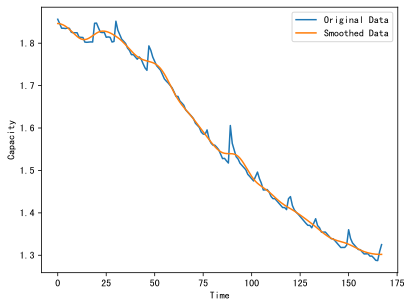

In [28]:
# 原始的时间序列数据
original_data = Battery['B0005'][1]
print(len(original_data))

# 小波平滑函数
def wavelet_smoothing(data, wavelet='db12', level=3):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    print(len(coeffs))
    print(len(coeffs[0]))
    print(len(coeffs[1]))
    print(len(coeffs[2]))
    print(len(coeffs[3]))
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.0
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

# 使用小波平滑
smoothed_data = wavelet_smoothing(original_data)

# 可视化原始数据和平滑后的数据
plt.plot(original_data, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity')

### 测试 nn.MultiheadAttention

In [20]:
# q=torch.randint(0,10,size=(10,9,8),dtype=torch.float32) #batch_size,seq_length,dim
# k=torch.randint(0,10,size=(10,7,4),dtype=torch.float32)
# v=torch.randint(0,10,size=(10,7,3),dtype=torch.float32)
# attention=nn.MultiheadAttention(embed_dim=8,num_heads=4,kdim=4,vdim=3,batch_first=True)

# q=torch.randint(0,10,size=(420,1,16),dtype=torch.float32) #batch_size,seq_length,dim
# k=torch.randint(0,10,size=(420,1,16),dtype=torch.float32)
# v=torch.randint(0,10,size=(420,1,1),dtype=torch.float32)

q=torch.randint(0,10,size=(1,1,16),dtype=torch.float32) #batch_size,seq_length,dim
k=torch.randint(0,10,size=(1,420,16),dtype=torch.float32)
v=torch.randint(0,10,size=(1,420,1),dtype=torch.float32)

attention=nn.MultiheadAttention(embed_dim=16,num_heads=4,kdim=16,vdim=1,batch_first=True)


attn_output, attn_output_weights=attention(q,k,v)
print(attn_output.shape)
print(attn_output_weights.shape)

torch.Size([1, 1, 16])
torch.Size([1, 1, 420])


### 降噪自编码器

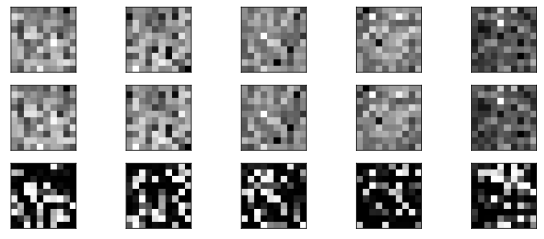

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 创建一个简单的降噪自编码器模型
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 定义参数
input_dim = 100  # 输入数据的维度
encoding_dim = 50  # 编码器的维度

# 创建降噪自编码器模型
autoencoder = DenoisingAutoencoder(input_dim, encoding_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# 生成一些带噪声的训练数据（这里使用随机生成的数据）
num_samples = 1000
X_train = torch.randn(num_samples, input_dim)

# 添加噪声到训练数据
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * torch.randn(X_train.size())

# 训练降噪自编码器
epochs = 100
batch_size = 32

for epoch in range(epochs):
    for i in range(0, num_samples, batch_size):
        batch_data = X_train_noisy[i:i+batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 使用训练好的模型去除噪声
autoencoder.eval()
denoised_data = autoencoder(X_train_noisy)

# 可视化一些示例数据（原始数据、带噪声的数据和去噪后的数据）
n = 5  # 可视化的示例数量
plt.figure(figsize=(10, 4))
for i in range(n):
    # 原始数据
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_train[i].reshape(10, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 带噪声的数据
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train_noisy[i].reshape(10, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 去噪后的数据
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_data[i].detach().numpy().reshape(10, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### 三维数据的残差网络

In [14]:
# 残差网络
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        print('Y.shape', Y.shape)
        
        out_conv2 = self.conv2(Y)
        print('out_conv2.shape', out_conv2.shape)
        
        Y = self.bn2(out_conv2)
        
        Y += X
        return F.relu(Y)

# blk = Residual(3,3)
# X = torch.rand(4, 3, 6, 6)
blk = Residual(1, 1)
X = torch.rand(30, 1, 4, 4)
Y = blk(X)
Y.shape

Y.shape torch.Size([30, 1, 4, 4])
out_conv2.shape torch.Size([30, 1, 4, 4])


torch.Size([30, 1, 4, 4])

### 一维卷积操作

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假设你有一个二维数据集，维度为 (N, D)，其中 N 表示批次大小，D 表示特征维度
N = 10
D = 20
data = torch.rand(N, D)

# 定义卷积核的参数
kernel_size = 3
stride = 1
in_channels = 1  # 输入数据的通道数，因为我们是在特征维度上进行一维卷积，所以通道数为1
out_channels = 1  # 输出数据的通道数

# 创建一维卷积层
conv1d_layer = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=1)

# 将输入数据从二维转换为三维，因为 nn.Conv1d 期望输入为三维张量 (N, C, L)，其中 C 是通道数，L 是序列长度
data = data.unsqueeze(1)  # 在通道维度上添加一个维度

# 执行一维卷积操作
conv_result = conv1d_layer(data)

# 输出结果的维度为 (N, out_channels, L_out)，其中 L_out 是输出序列的长度
print(conv_result.shape)


torch.Size([10, 1, 20])


### 二维数据的残差网络

In [16]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)


blk = Residual1D(1, 8)
X = torch.rand(30, 1, 16)
Y = blk(X)
Y.shape

torch.Size([30, 8, 16])

In [1]:
for i in [1,2,4,6,8]:
    print(i)

1
2
4
6
8
